# Korea Datathon Tutorial

The aim of this tutorial is to get you familarized with using Colab to run queries with MIMIC database. 

### Prerequisites

* Gmail account sent to organizer.
* fundamentals on SQL and Statical analysis

## Setup

* Before running any cell in the script, please make sure that there is a green check mark before "CONNECTED" on top right corner, if not, please click "CONNECTED" button to connect to a random backend.

* You can now run the following cell by clicking on the triangle button when you hover over the [ ] space on the top-left corner of the code cell below or Press Shift+Enter.

In [1]:
# Import libraries
import numpy as np
import tensorflow as tf
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from tableone import TableOne


# Imports for printing out pretty pandas dataframes
from IPython.display import display, HTML

# Imports for accessing Datathon data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

ModuleNotFoundError: No module named 'tableone'

Before running any queries using BigQuery, you need to first authenticate yourself by running the following cell. If you are running it for the first time, it will ask you to follow a link to log in using your Gmail account, and accept the data access requests to your profile. Once this is done, it will generate a string of verification code, which you should paste back to the cell below and press enter.

In [ ]:
auth.authenticate_user()

* The data-hosting project physionet-data has read-only access, as a result, you need to set a default project that you have BigQuery access to.

* Note that during the actual datathon, all participants will be divided into teams and a separate Google Cloud project_id will be provided to each team. 

In [ ]:
project_id='datathon-korea-2019'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id

Let's define a sql wrapper with our project_id configured

In [ ]:
# Read data from BigQuery into pandas dataframes.
def run_query(query):
    return pd.io.gbq.read_gbq(query, project_id=project_id, verbose=False, configuration={'query':{'useLegacySql': False}})

*OK*, that's it for setup, now let's get our hands on the MIMIC demo data!

## sample queries


* Select all columns from a **`patients`** table where **subject_id** is [10006, 10040, 10111].

In [3]:
run_query(
    """
    SELECT * 

    FROM `physionet-data.mimiciii_demo.patients`
    
    WHERE 
        subject_id = 10006 OR
        subject_id = 10040 OR
        subject_id = 10111
    """
)

NameError: name 'run_query' is not defined

* Inner join the tree tables "patients", "admissions", "icustays"

In [25]:
run_query("""
WITH `ICU-ADM` as(
    SELECT * 
    FROM `physionet-data.mimiciii_demo.icustays`
    LEFT JOIN `physionet-data.mimiciii_demo.admissions` 
        USING (subject_id, hadm_id)),

`ICU_ADM_PAT` as(
    SELECT * 
    from `ICU-ADM`
    LEFT JOIN `physionet-data.mimiciii_demo.patients` 
        USING (subject_id))
        
SELECT icustay_id, hadm_id, subject_id, dob,
       admittime, dischtime , intime,
       outtime,ethnicity, gender 
FROM `icu-adm-pat`
LIMIT 5


""")

,icustay_id,hadm_id,subject_id,dob,admittime,dischtime,intime,outtime,ethnicity,gender
0,204881,199207,10017,2075-09-21,2149-05-26 17:19:00,2149-06-03 18:42:00,2149-05-29 18:52:29,2149-05-31 22:19:17,WHITE,F
1,295043,170883,10124,2108-12-20,2192-04-16 20:57:00,2192-05-15 19:28:00,2192-04-24 02:29:49,2192-04-26 23:59:45,WHITE,F
2,293429,168803,40503,2097-11-14,2186-07-06 19:59:00,2186-07-07 19:00:00,2186-07-06 19:59:36,2186-07-07 20:48:07,WHITE,F
3,279529,182879,40601,2112-01-20,2184-08-04 05:44:00,2184-08-10 15:30:00,2184-08-04 05:45:07,2184-08-06 17:26:43,WHITE,F
4,249695,168233,10088,2029-07-09,2107-01-29 04:00:00,2107-02-10 12:00:00,2107-01-29 04:02:15,2107-01-30 18:58:45,WHITE,M


The **chartevents** table contains charted data such as vital sign measurements. The itemids 211 and 220045 correspond to heart rate (you can double check this in the d_items table).

1. Write a query to select all of the heart rate measurements in the chartevents table. Use the GROUP BY keyword to find the maximum heart rate for each patient. Note this query may take some time.
2. Modify the query to exclude patients with a maximum heart rate of > 140 bpm(possibly data error).

In [12]:
##1
df = run_query("""
    SELECT icustay_id, max(valuenum) as HeartRate_Max
    FROM `physionet-data.mimiciii_demo.chartevents`
    WHERE itemid = 211
    GROUP BY icustay_id;
      """)
df.head()

,icustay_id,HeartRate_Max
0,248755,76.0
1,234989,88.0
2,228977,92.0
3,258147,96.0
4,243600,96.0


In [13]:
##2 
df = run_query("""
      SELECT icustay_id, max(valuenum) as HeartRate_Max
      FROM `physionet-data.mimiciii_demo.chartevents`
      WHERE itemid = 211
      GROUP BY icustay_id
      HAVING max(valuenum) <= 140;
      """)
df.head()

,icustay_id,HeartRate_Max
0,248755,76.0
1,234989,88.0
2,228977,92.0
3,258147,96.0
4,243600,96.0


1. Get the list of subject_id, patient_id with thier primary diagnoses ICD code and their age in years.
2. And only take thier first admit

It is important to note that patients in mimiciii data with their age above 91.5 are masked by shifting thier DOB. Therefore if you are going to use age as one of your features in your model, threshold of 91.5 has to be set or simply ignore them in your study.

In [15]:
##1

df = run_query("""

      with cohort as
      (
      select * 
      from `physionet-data.mimiciii_demo.admissions`
      ),

      primary_admit_diag as 
      (
        select hadm_id, icd9_code
        from `physionet-data.mimiciii_demo.diagnoses_icd`
        where seq_num = 1
        order by hadm_id
      ),

      age_raw as
      (
        select hadm_id,
               datetime_diff(admittime ,dob, day)/365 as crude_age 
        from `physionet-data.mimiciii_demo.patients`
        left join `physionet-data.mimiciii_demo.admissions` using (subject_id)
      ),

      age as 
      (
        select  hadm_id,
                case when  crude_age  > 91.5 then 91.5 else
                           crude_age  end age
        from age_raw
      )

      select cohort.subject_id ,cohort.hadm_id, age.age, primary_admit_diag.icd9_code
      from cohort
      left join age using (hadm_id)
      left join primary_admit_diag using (hadm_id)
      limit 5
      """)
df.head()



,subject_id,hadm_id,age,icd9_code
0,10017,199207,73.726027,81201
1,10029,132349,78.501370,0380
2,10033,157235,81.679452,24220
3,10038,111115,88.093151,99667
4,10043,168674,76.071233,51881


In [14]:
##2
df= run_query("""

  with cohort as
  (
  select * 
  from `physionet-data.mimiciii_demo.admissions`
  ),

  primary_admit_diag as 
  (
    select hadm_id, icd9_code
    from `physionet-data.mimiciii_demo.diagnoses_icd`
    where seq_num = 1
    order by hadm_id
  ),

  age_raw as
  (
    select hadm_id,
           date_diff(cast(admittime as date),cast(dob as date),day)/365 as crude_age 
    from `physionet-data.mimiciii_demo.patients`
    left join `physionet-data.mimiciii_demo.admissions` using (subject_id)
  ),

  age as 
  (
    select  hadm_id,
            case when  crude_age  > 91.5 then 91.5 else
                       crude_age  end age
    from age_raw
  )

  select subject_id, hadm_id, age, icd9_code, short_title
  from (
  select cohort.subject_id ,cohort.hadm_id, age.age, primary_admit_diag.icd9_code, short_title,
         row_number() over (partition by cohort.subject_id order by age.age asc) row_num 
  from cohort
  left join age using (hadm_id)
  left join primary_admit_diag using (hadm_id)
  left join `physionet-data.mimiciii_demo.d_icd_diagnoses` using (icd9_code)
      )
  where row_num = 1
  order by subject_id desc

""")

df.head()

,subject_id,hadm_id,age,icd9_code,short_title
0,44228,103379,58.186301,03842,E coli septicemia
1,44222,192189,73.112329,42781,Sinoatrial node dysfunct
2,44212,163189,45.468493,03811,Meth susc Staph aur sept
3,44154,174245,91.500000,0389,Septicemia NOS
4,44083,125157,54.501370,1510,Mal neo stomach cardia


## General Workflow 

In general, data extraction from MIMICiii data can be divived in to several steps. tables created from each step can be merged to generate a bigger table which will be used for our final analysis. 

1. Cohort selection + demographics
2. Diagnosis
3. Labtest results
4. VitalSign
5. Merge 

### 1. Chort Selection: First icustay cases with age > 60

In [125]:
df = run_query("""
      with first_icu as
      (
      select subject_id, hadm_id, min(intime) as intime, min(outtime) as outtime 
      from `physionet-data.mimiciii_demo.icustays`
      group by hadm_id, subject_id
      ),

      age_all as
      (
      select subject_id, hadm_id, gender, ethnicity, marital_status,
             if(datetime_diff(admittime,dob,day)/365.2 > 91.5, 91.5,
             datetime_diff(admittime,dob,day)/365.2) age

      from `physionet-data.mimiciii_demo.admissions`
      left join `physionet-data.mimiciii_demo.patients` using (subject_id)
      ),

      age_over_60 as 
      (
      select *
      from age_all
      where age > 60
      )

      select *
      from first_icu
      inner join age_over_60 using (subject_id, hadm_id)
      order by hadm_id  
""")
print("number of cases: {}".format(len(df)))
df.head()

number of cases:102


,subject_id,hadm_id,intime,outtime,gender,ethnicity,marital_status,age
0,10056,100375,2129-05-02 00:12:39,2129-05-03 01:23:25,F,WHITE,UNKNOWN (DEFAULT),83.184556
1,42430,100969,2142-11-26 21:21:21,2142-11-29 17:36:20,M,WHITE,None,80.969332
2,10026,103770,2195-05-17 07:40:18,2195-05-19 17:24:25,F,WHITE,None,91.500000
3,40612,104697,2159-11-17 03:31:23,2159-11-20 16:38:19,F,HISPANIC OR LATINO,SINGLE,86.270537
4,10117,105150,2138-11-12 03:18:24,2138-11-14 19:29:44,F,UNKNOWN/NOT SPECIFIED,SINGLE,66.519715


### 2. Diagnosis: Hypertension, Afib 

In [127]:
df = run_query("""
        select hadm_id, subject_id,
               max(case when (substr(icd9_code,1,4) between '401' and '405') then 1 else 0 end)as hypertension,
               max(case when (icd9_code like '4273%') then 1 else 0 end) as afib 

        from `physionet-data.mimiciii_demo.diagnoses_icd`
        group by hadm_id, subject_id

""")
df.head()

,hadm_id,subject_id,hypertension,afib
0,171628,42066,0,0
1,189483,10036,0,0
2,161765,40456,0,0
3,103379,44228,0,0
4,145203,10061,0,0


### 3. *Labtest* results: for the first 24 hours of admit time 

In [128]:
df = run_query("""
          with lab_tests as (
              select hadm_id, charttime, value,
                     case when itemid in (51300,51301) then 'wbc'
                          when itemid in (50811,51222) then 'hemoglobin'
                          when itemid in (51265) then 'platelet'
                          when itemid in (50824,50983) then 'sodium'
                          when itemid in (50822,50971) then 'potassium'
                          else null end as label,
                     valuenum
              from `physionet-data.mimiciii_demo.labevents`
          )

          , lab_tests_cohort as (
              select hadm_id, label, valuenum, charttime
              from `datathon-korea-2018.Intermediate_tables.cohort` 
              left join lab_tests lab using (hadm_id)
              where charttime between intime and datetime_add(intime,interval 1 day)
                    and label is not null
                    and valuenum is not null
                    and valuenum > 0
          ),

          lab_summary as (
              select distinct hadm_id, label,
               first_value(valuenum) over (partition by hadm_id, label order by charttime) as fst_val
              from lab_tests_cohort
          )

          select hadm_id
          , max(case when label = 'chloride' then 1 else 0 end) as lab_chloride_flag
          , max(case when label = 'chloride' then fst_val else null end) as lab_chloride_first
          , max(case when label = 'platelet' then 1 else 0 end) as lab_platelet_flag
          , max(case when label = 'platelet' then fst_val else null end) as lab_platelet_first
          , max(case when label = 'creatinine' then 1 else 0 end) as lab_creatinine_flag
          , max(case when label = 'creatinine' then fst_val else null end) as lab_creatinine_first
          , max(case when label = 'potassium' then 1 else 0 end) as lab_potassium_flag
          , max(case when label = 'potassium' then fst_val else null end) as lab_potassium_first
          from lab_summary
          group by hadm_id
""")

df.head()

,hadm_id,lab_chloride_flag,lab_chloride_first,lab_platelet_flag,lab_platelet_first,lab_creatinine_flag,lab_creatinine_first,lab_potassium_flag,lab_potassium_first
0,100375,0,NaN,0,NaN,0,NaN,1,4.5
1,133283,0,NaN,0,NaN,0,NaN,1,3.7
2,159647,0,NaN,0,NaN,0,NaN,1,4.2
3,199207,0,NaN,1,202.0,0,NaN,1,3.0
4,167957,0,NaN,1,223.0,0,NaN,1,3.0


### 4. Vital_sign: heart_rate,temp


In [129]:
df = run_query("""
with vital_signs as (
    select hadm_id,
           charttime,
           case when itemid in (223762,676,223761,678) then 'temp'
                when itemid in (211,220045) then 'heart_rate'
            else null end as label,
            case when itemid in (211,220045) and (valuenum <= 0 or valuenum >= 300) then null
                 when itemid in (223762,676) and valuenum < 10 then null
                 -- convert F to C
                 when itemid in (223761,678) then (valuenum-32)/1.8
            else valuenum end as valuenum
    from `physionet-data.mimiciii_demo.chartevents`
)

, vital_signs_cohort as (
    select hadm_id, charttime, label, valuenum
    from `datathon-korea-2018.Intermediate_tables.cohort`
    left join vital_signs using (hadm_id)
    where charttime between intime and datetime_add(intime,interval 1 day)
          and charttime between intime and outtime
          and label is not null
          and valuenum is not null
),

summary as (
    select distinct hadm_id, label
    , first_value(valuenum) over (partition by hadm_id, label order by charttime) as fst_val
    , first_value(valuenum) over (partition by hadm_id, label order by valuenum) as min_val
    , first_value(valuenum) over (partition by hadm_id, label order by valuenum desc) as max_val
    from vital_signs_cohort
)

select hadm_id
, max(case when label = 'temp' then 1 else 0 end) as vs_temp_flag
, max(case when label = 'temp' then fst_val else null end) as vs_temp_first
, max(case when label = 'heart_rate' then 1 else 0 end) as vs_heart_rate_flag
, max(case when label = 'heart_rate' then fst_val else null end) as vs_heart_rate_first
from summary
group by hadm_id
""")

df.head()

,hadm_id,vs_temp_flag,vs_temp_first,vs_heart_rate_flag,vs_heart_rate_first
0,126002,1,37.111111,1,48.0
1,126949,1,35.888888,1,50.0
2,122098,1,37.166668,1,60.0
3,114867,1,36.111111,1,64.0
4,151323,1,34.722222,1,68.0


## Regression for correlation analysis

We may want to find the correlation between some input variables and outcome varialbe.
* our hypothesis would be whether there is any linear correlation between patients age(input) when they got admitted to ICU and thier length of stay in ICU(outcome). 
* It is apprent from the scatter plot that the patients age is not suffient enought to explain the length of stay.

127
          stay       age
stay  1.000000 -0.290222
age  -0.290222  1.000000


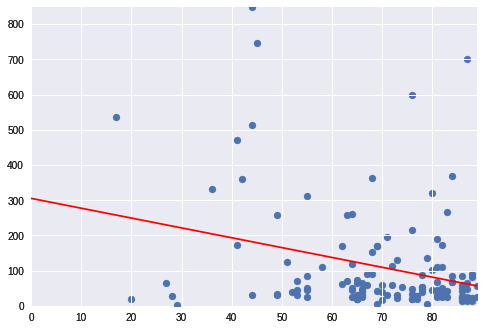

In [158]:
df = run_query('''
WITH re AS (
SELECT
  DATETIME_DIFF(icu.outtime, icu.intime, HOUR) AS icu_length_of_stay,
  DATE_DIFF(DATE(icu.intime), DATE(pat.dob), YEAR) AS age
FROM `physionet-data.mimiciii_demo.icustays` AS icu
INNER JOIN `physionet-data.mimiciii_demo.patients` AS pat
  ON icu.subject_id = pat.subject_id)
SELECT
  icu_length_of_stay AS stay,
  age
FROM re
WHERE age < 91.5
''')

print(len(df))
print(df.corr(method='pearson', min_periods=1))
model=linear_model.LinearRegression()
model.fit(X= df["age"].values.reshape(-1, 1), y = df["stay"].values)

coef = model.coef_ 
intercept = model.intercept_

fig=plt.figure()

ax1=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)
ax1.scatter(df["age"],df["stay"])
ax2.plot([0,90],[intercept,intercept + (coef*90)], "R")
ax1.set_xlim([0,max(df["age"])])
ax2.set_xlim([0,max(df["age"])])
ax1.set_ylim([0,max(df["stay"])])
ax2.set_ylim([0,max(df["stay"])])

plt.show()

We may add other covariates to know the significance of the length of icu stays compared to rest the covariates
* possible covariates include the number of visits, gender, 

Number of rows in dataframe: 127


,age,first_stay,surgical,icu_length_of_stay
count,127.000000,127.000000,127.000000,127.000000
mean,69.515565,0.275591,0.212598,4.590551
std,15.870411,0.448581,0.410766,6.379972
min,17.202740,0.000000,0.000000,0.000000
25%,63.717808,0.000000,0.000000,1.000000
50%,72.668493,0.000000,0.000000,2.000000
75%,81.754795,1.000000,0.000000,4.000000
max,88.794521,1.000000,1.000000,36.000000


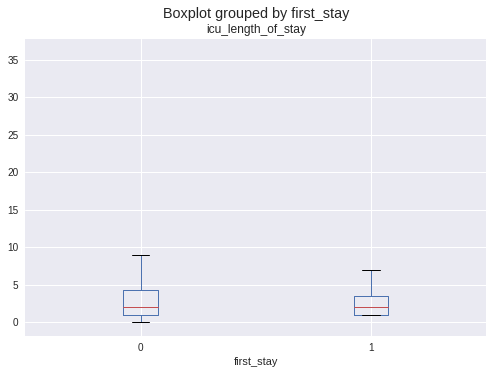

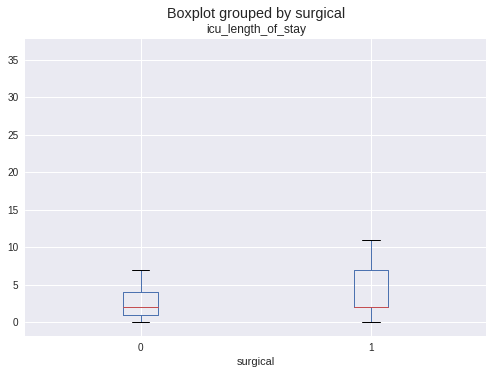

In [192]:
df_raw = run_query('''

WITH co AS (
  SELECT
    icu.subject_id,
    icu.hadm_id,
    icu.icustay_id,
    pat.dob,
    DATETIME_DIFF(icu.outtime, icu.intime, DAY) AS icu_length_of_stay,
    DATE_DIFF(DATE(icu.intime), DATE(pat.dob), day)/365 AS age,
    RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) AS icustay_id_order
  FROM `physionet-data.mimiciii_demo.icustays` AS icu
  INNER JOIN `physionet-data.mimiciii_demo.patients` AS pat
    ON icu.subject_id = pat.subject_id
  ORDER BY hadm_id DESC),
  
serv AS (
  SELECT
    icu.hadm_id,
    icu.icustay_id,
    se.curr_service,
    IF(curr_service like '%SURG' OR curr_service = 'ORTHO', 1, 0) AS surgical,
    RANK() OVER (PARTITION BY icu.hadm_id ORDER BY se.transfertime DESC) as rank
  FROM `physionet-data.mimiciii_demo.icustays` AS icu
  LEFT JOIN `physionet-data.mimiciii_demo.services` AS se
  ON icu.hadm_id = se.hadm_id
  AND se.transfertime < DATETIME_ADD(icu.intime, INTERVAL 12 HOUR)
  ORDER BY icustay_id)
  
SELECT
  co.subject_id,
  co.hadm_id,
  IF(co.icu_length_of_stay < 2, 1, 0) AS short_stay,
  co.icustay_id,
  co.icu_length_of_stay,
  co.age,
  IF(co.icustay_id_order = 1, 0, 1) AS first_stay,
  IF(serv.surgical = 1, 1, 0) AS surgical
FROM co
LEFT JOIN serv USING (icustay_id, hadm_id)
WHERE serv.rank = 1 AND age < 91.5
ORDER BY subject_id, icustay_id_order
''')

print('Number of rows in dataframe: %d' % len(df))

df = df_raw[["age","first_stay","surgical","icu_length_of_stay"]]
## print df_summary
display(df.describe())

## box plot icu_stay vs first_stay
df.boxplot(column = "icu_length_of_stay", by = "first_stay")
## box plot icu_stay vs surgical
df.boxplot(column = "icu_length_of_stay", by = "surgical")


In [193]:
model = linear_model.LinearRegression(fit_intercept=True, normalize=False)

as_matrix = df[["age","surgical","first_stay","icu_length_of_stay"]].as_matrix()

X = as_matrix[:,[0,1,2]]
Y = as_matrix[:,3]

model.fit(X = X, y = Y)

coefs = model.coef_

pd.DataFrame({"covariates":list(df)[:-1],
              "weights":coefs})

,covariates,weights
0,age,-0.118147
1,first_stay,1.423742
2,surgical,-0.757683


## Classification prediction

This time we are interested in binary classification and we will be using the patients' age and whether it is the first ICU stay to predict whether the ICU stay will be a short one. With only 127 data points in total, we don't expect to actually build an accurate or useful predictor, but it should serve the purpose of showing how a model can be trained and used using Tensorflow within Colab.

* This time round, we will be using **tensorflow** to build our model. 
* We will split our data into train(80%) and test(20%) samples since our objective now is to predict unforseeen cases(teset) based on the past(train).

In [217]:
df = df_raw.filter(regex = "^((?!id).)*$")
df = df.reindex(np.random.permutation(df.index))

train_frac = 0.8

train_df = df[:int(len(df)*(train_frac))]
test_df = df[~df.index.isin(train_df.index)]

print "Training data summary:"
display(train_df.describe())

print "Validation data summary:"
display(test_df.describe())

Training data summary:


,short_stay,icu_length_of_stay,age,first_stay,surgical
count,101.000000,101.000000,101.000000,101.000000,101.000000
mean,0.326733,4.702970,68.990696,0.287129,0.198020
std,0.471358,6.679138,16.340316,0.454679,0.400495
min,0.000000,0.000000,17.202740,0.000000,0.000000
25%,0.000000,1.000000,62.504110,0.000000,0.000000
50%,0.000000,2.000000,72.668493,0.000000,0.000000
75%,1.000000,4.000000,81.695890,1.000000,0.000000
max,1.000000,36.000000,88.794521,1.000000,1.000000


Validation data summary:


,short_stay,icu_length_of_stay,age,first_stay,surgical
count,26.000000,26.000000,26.000000,26.000000,26.000000
mean,0.307692,4.153846,71.554478,0.230769,0.269231
std,0.470679,5.143480,13.998729,0.429669,0.452344
min,0.000000,1.000000,27.032877,0.000000,0.000000
25%,0.000000,1.000000,65.540411,0.000000,0.000000
50%,0.000000,2.000000,73.256164,0.000000,0.000000
75%,1.000000,4.500000,82.219863,0.000000,0.750000
max,1.000000,25.000000,88.120548,1.000000,1.000000


icu_length_of_stay  age  surgical
short_stay first_stay                                   
0          0                           49   49        49
           1                           19   19        19
1          0                           23   23        23
           1                           10   10        10

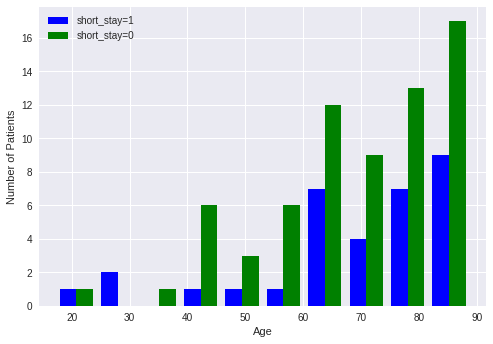

In [224]:
display(train_df.groupby(['short_stay', 'first_stay']).count())
fig, ax = plt.subplots()
shorts = train_df[train_df.short_stay==1].age 
longs = train_df[train_df.short_stay==0].age 
colors = ['b', 'g']
ax.hist([shorts, longs], bins=10, color=colors, label=['short_stay=1', 'short_stay=0'])
ax.set_xlabel('Age')
ax.set_ylabel('Number of Patients')
plt.legend(loc='upper left')
plt.show()

In [230]:
#@title ML Training example {display-mode:"both"}
BATCH_SIZE = 12        # @param
NUM_EPOCHS = 100       # @param
HIDDEN_UNITS=[10, 10] # @param


first_stay = tf.feature_column.numeric_column('first_stay')
age = tf.feature_column.numeric_column('age')

# Build linear regressor
classifier = tf.estimator.DNNClassifier(
    feature_columns=[first_stay, age],
    hidden_units=HIDDEN_UNITS)

# Train the Model.
model = classifier.train(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        x=train_df,
        y=train_df['short_stay'],
        num_epochs=100,
        batch_size=BATCH_SIZE,
        shuffle=True),
    steps=100)

# Evaluate the model.
eval_result = classifier.evaluate(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        x=test_df,
        y=test_df['short_stay'],
        batch_size=BATCH_SIZE,
        shuffle=False))

display(eval_result)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.


{'accuracy': 0.6923077,
 'accuracy_baseline': 0.6923077,
 'auc': 0.34375003,
 'auc_precision_recall': 0.22559091,
 'average_loss': 0.6407092,
 'global_step': 100,
 'label/mean': 0.30769232,
 'loss': 5.552813,
 'precision': 0.0,
 'prediction/mean': 0.34811872,
 'recall': 0.0}

In [ ]:
with hypertension as
(
select max(case when (substr(icd9_code,1,4) between '401' and '405') then 1 else 0 end)as hypertension 
       max(case when (icd9_code like '4273%') then 1 else 0 end)as afib 

from `physionet-data.mimiciii_demo.diagnoses_icd`
)

select * 
from 
 


